Part 1 - 业务问题和库导入

In [2]:
# 导入库

import os

# 数值和数据处理库
import numpy as np
import pandas as pd

# 数据可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习相关
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 图像处理
import cv2

# PyTorch深度学习框架
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

# 检查GPU可用性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


Part 2 - 数据库配置

In [3]:
# 默认图像大小（如果内存不足可以尝试128）
IMG_SIZE = 256
BATCH_SIZE = 8

# 图像和掩码的目录
IMG_DIR = './archive/frames'
MASK_DIR = './archive/masks'

# 所有图像文件列表
all_files = sorted(os.listdir(IMG_DIR))

Part 3 - 训练和测试数据集划分

In [4]:
# 将文件分割为训练集、验证集和测试集
train_files, test_files = train_test_split(all_files, test_size=0.15, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.15, random_state=42)

print(f"训练集: {len(train_files)}, 验证集: {len(val_files)}, 测试集: {len(test_files)}")

# CT图像分割的数据生成器（继承自PyTorch Dataset）
class CTDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir, img_size=IMG_SIZE, transform=None):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        
        # 加载图像
        img = cv2.imread(os.path.join(self.img_dir, fname), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = img.astype(np.float32)
        
        # 加载掩码
        mask = cv2.imread(os.path.join(self.mask_dir, fname), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = (mask > 127).astype(np.float32)  # 二值化掩码
        
        # 转换为PyTorch张量
        img = torch.from_numpy(img).unsqueeze(0)  # 添加通道维度
        mask = torch.from_numpy(mask).unsqueeze(0)
        
        return img, mask

# 创建数据集实例
train_dataset = CTDataset(train_files, IMG_DIR, MASK_DIR, IMG_SIZE)
val_dataset = CTDataset(val_files, IMG_DIR, MASK_DIR, IMG_SIZE)
test_dataset = CTDataset(test_files, IMG_DIR, MASK_DIR, IMG_SIZE)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

训练集: 1971, 验证集: 348, 测试集: 410


Part 4 - U-Net网络架构

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        # 编码器：下采样路径
        self.conv1_1 = nn.Conv2d(in_channels, 16, 3, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        
        self.conv4_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2)
        
        # 桥接：U-Net的瓶颈
        self.conv5_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5_2 = nn.Conv2d(256, 256, 3, padding=1)
        
        # 解码器：上采样路径
        self.up6 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv6_1 = nn.Conv2d(256, 128, 3, padding=1)  # 256因为连接
        self.conv6_2 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.up7 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv7_1 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv7_2 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.up8 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv8_1 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv8_2 = nn.Conv2d(32, 32, 3, padding=1)
        
        self.up9 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv9_1 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv9_2 = nn.Conv2d(16, 16, 3, padding=1)
        
        # 输出层：1通道sigmoid激活（用于二元分割）
        self.conv_out = nn.Conv2d(16, out_channels, 1)
        
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 编码器
        c1 = self.relu(self.conv1_1(x))
        c1 = self.relu(self.conv1_2(c1))
        p1 = self.pool1(c1)
        
        c2 = self.relu(self.conv2_1(p1))
        c2 = self.relu(self.conv2_2(c2))
        p2 = self.pool2(c2)
        
        c3 = self.relu(self.conv3_1(p2))
        c3 = self.relu(self.conv3_2(c3))
        p3 = self.pool3(c3)
        
        c4 = self.relu(self.conv4_1(p3))
        c4 = self.relu(self.conv4_2(c4))
        p4 = self.pool4(c4)
        
        # 桥接
        c5 = self.relu(self.conv5_1(p4))
        c5 = self.relu(self.conv5_2(c5))
        
        # 解码器
        u6 = self.up6(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.relu(self.conv6_1(u6))
        c6 = self.relu(self.conv6_2(c6))
        
        u7 = self.up7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.relu(self.conv7_1(u7))
        c7 = self.relu(self.conv7_2(c7))
        
        u8 = self.up8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.relu(self.conv8_1(u8))
        c8 = self.relu(self.conv8_2(c8))
        
        u9 = self.up9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.relu(self.conv9_1(u9))
        c9 = self.relu(self.conv9_2(c9))
        
        # 输出
        outputs = self.sigmoid(self.conv_out(c9))
        
        return outputs

# 创建模型实例
model = UNet(in_channels=1, out_channels=1).to(device)

Part 5 - 模型1 U-Net训练

In [6]:
# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 显示模型架构摘要
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"模型参数总数: {count_parameters(model):,}")

# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            # 计算像素准确率
            pred_masks = (outputs > 0.5).float()
            acc = (pred_masks == masks).float().mean()
            train_acc += acc.item()
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                pred_masks = (outputs > 0.5).float()
                acc = (pred_masks == masks).float().mean()
                val_acc += acc.item()
        
        # 计算平均值
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'轮次 {epoch+1}/{num_epochs}: '
              f'训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f}, '
              f'验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.4f}')
    
    return history

# 训练模型
import time
start_time = time.time()
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
end_time = time.time()
print(f"训练用时: {end_time - start_time:.2f}秒")

模型参数总数: 1,940,817
轮次 1/5: 训练损失: 0.1007, 训练准确率: 0.9702, 验证损失: 0.0604, 验证准确率: 0.9851
轮次 2/5: 训练损失: 0.0606, 训练准确率: 0.9845, 验证损失: 0.0559, 验证准确率: 0.9851
轮次 3/5: 训练损失: 0.0525, 训练准确率: 0.9845, 验证损失: 0.0450, 验证准确率: 0.9851
轮次 4/5: 训练损失: 0.0418, 训练准确率: 0.9845, 验证损失: 0.0348, 验证准确率: 0.9851
轮次 5/5: 训练损失: 0.0367, 训练准确率: 0.9851, 验证损失: 0.0317, 验证准确率: 0.9884
训练用时: 199.79秒


Part 6 - 指标和评估

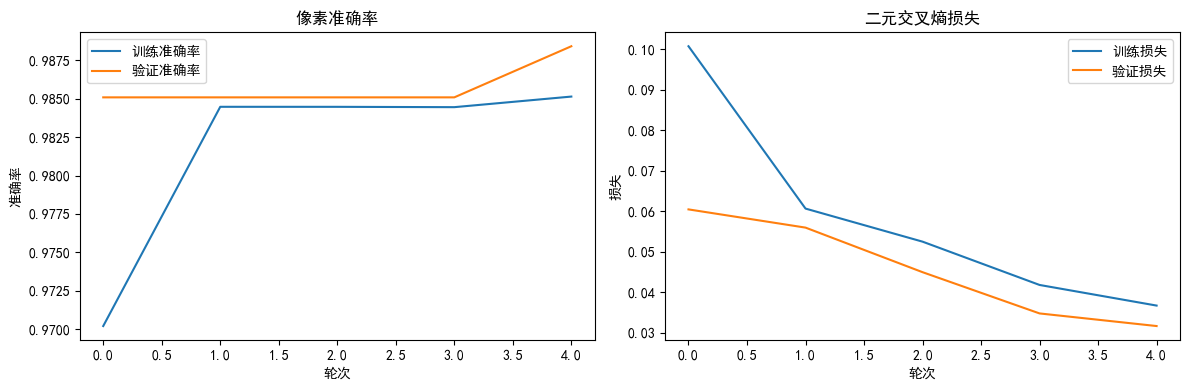

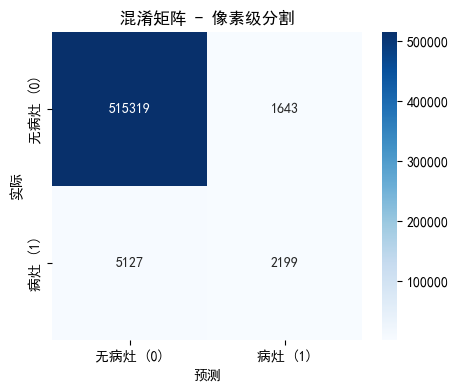

              precision    recall  f1-score   support

     无病灶 (0)     0.9901    0.9968    0.9935    516962
      病灶 (1)     0.5724    0.3002    0.3938      7326

    accuracy                         0.9871    524288
   macro avg     0.7813    0.6485    0.6936    524288
weighted avg     0.9843    0.9871    0.9851    524288



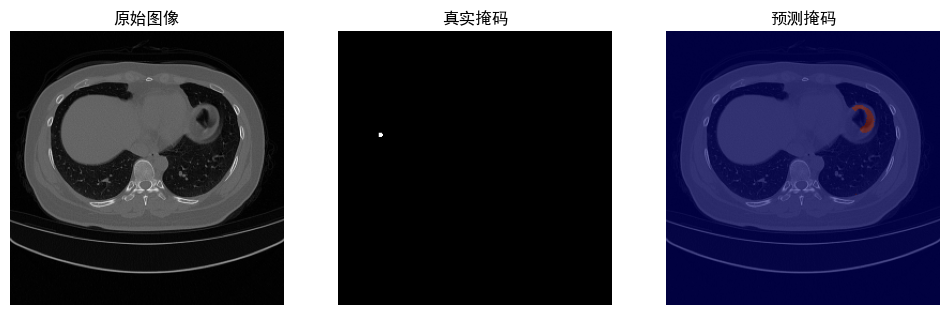

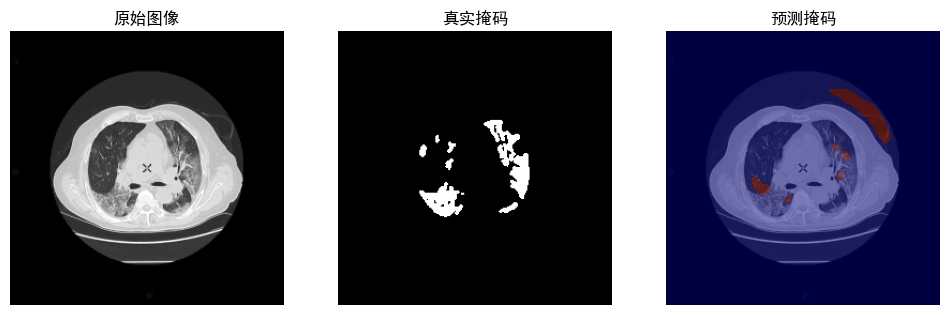

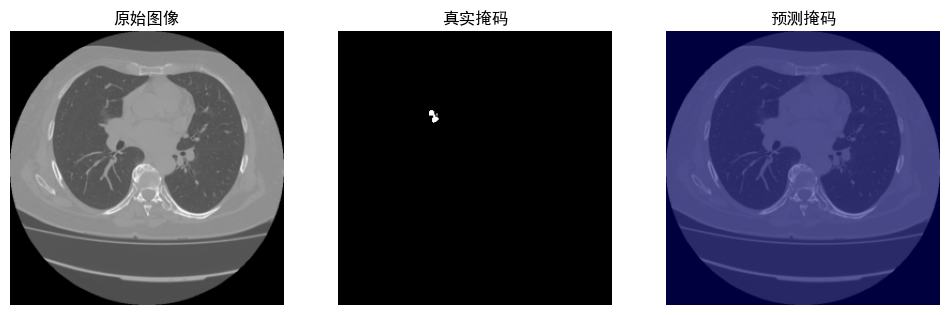

In [9]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties

# 配置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Heiti TC', 'Microsoft YaHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

plt.figure(figsize=(12,4))

# 准确率图
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='训练准确率')
plt.plot(history['val_acc'], label='验证准确率')
plt.xlabel('轮次')
plt.ylabel('准确率')
plt.legend()
plt.title('像素准确率')

# 损失图
plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='训练损失')
plt.plot(history['val_loss'], label='验证损失')
plt.xlabel('轮次')
plt.ylabel('损失')
plt.legend()
plt.title('二元交叉熵损失')

plt.tight_layout()
plt.show()

# 从测试集获取一个批次
model.eval()
with torch.no_grad():
    for imgs, masks_true in test_loader:
        imgs, masks_true = imgs.to(device), masks_true.to(device)
        masks_pred = model(imgs)
        break

# 展平掩码（逐像素）
all_true = []
all_pred = []
for i in range(masks_true.shape[0]):
    true_mask = masks_true[i][0].cpu().numpy().astype(np.uint8).flatten()
    pred_mask = (masks_pred[i][0] > 0.5).cpu().numpy().astype(np.uint8).flatten()
    all_true.extend(true_mask)
    all_pred.extend(pred_mask)

# 混淆矩阵
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['无病灶 (0)', '病灶 (1)'],
            yticklabels=['无病灶 (0)', '病灶 (1)'])
plt.xlabel("预测")
plt.ylabel("实际")
plt.title("混淆矩阵 - 像素级分割")
plt.show()

# 分类报告
target_names = ['无病灶 (0)', '病灶 (1)']
print(classification_report(all_true, all_pred, target_names=target_names, digits=4))

# 可视化测试结果
imgs_cpu = imgs.cpu()
masks_true_cpu = masks_true.cpu()
masks_pred_cpu = masks_pred.cpu()

for i in range(min(3, imgs.shape[0])):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(imgs_cpu[i][0], cmap='gray')
    plt.title("原始图像")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks_true_cpu[i][0], cmap='gray')
    plt.title("真实掩码")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(imgs_cpu[i][0], cmap='gray')
    plt.imshow(masks_pred_cpu[i][0] > 0.5, cmap='jet', alpha=0.5)
    plt.title("预测掩码")
    plt.axis('off')
    plt.show()

# 保存神经网络模型 - U-Net 1
torch.save(model.state_dict(), 'unet_1_segmentacao.pth')
# 或者保存整个模型
torch.save(model, 'unet_1_segmentacao_complete.pth')

Part 7 - 使用U-Net模型1进行图像预测

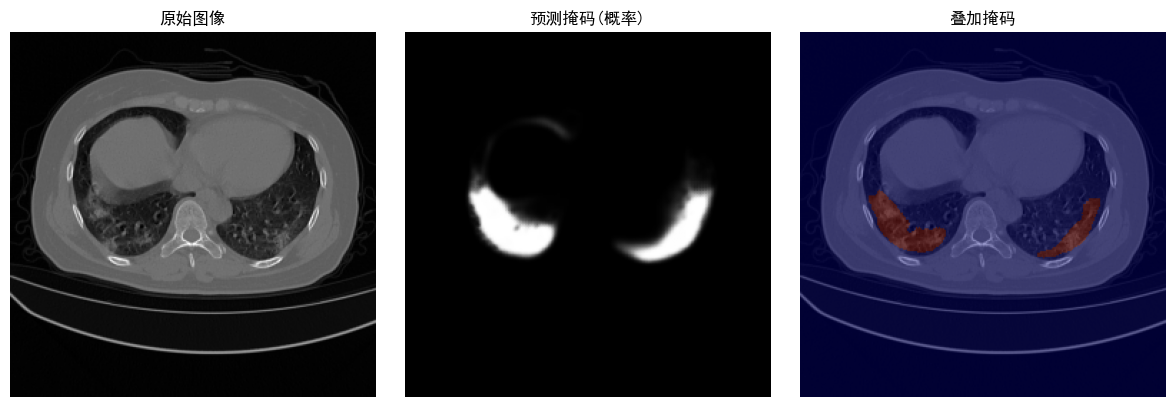

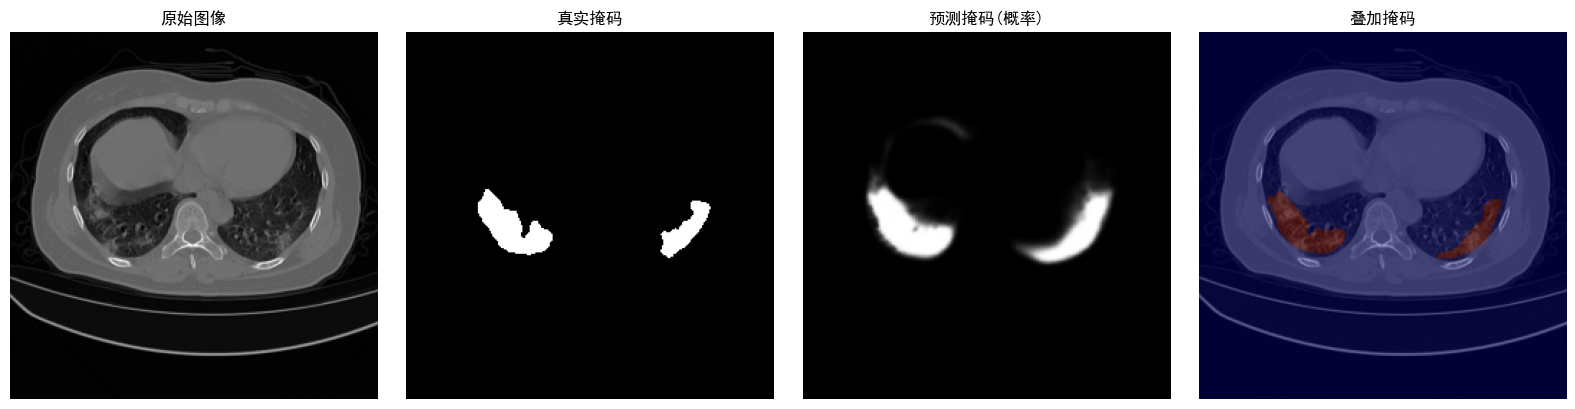

像素级准确率(图像): 0.9923
PyTorch模型报告的准确率: 0.9875


In [12]:
# 加载保存的模型
model_pred = UNet(in_channels=1, out_channels=1).to(device)
model_pred.load_state_dict(torch.load('unet_1_segmentacao.pth'))
model_pred.eval()

frames_dir = './archive/frames'
img_filename = 'Jun_coronacases_case10_118.png'  # 或列表中的任何文件名
img_path = os.path.join(frames_dir, img_filename)

# 以灰度模式加载图像
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 调整大小到(256, 256)
img = cv2.resize(img, (256, 256))

# 将像素值归一化到[0, 1]
img = img / 255.0

# 转换为PyTorch张量并添加批次和通道维度: (1, 1, 256, 256)
img_input = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0).to(device)

# 进行预测
with torch.no_grad():
    mask_pred = model_pred(img_input)[0, 0].cpu().numpy()
mask_pred_bin = (mask_pred > 0.5).astype(np.uint8)

# 可视化
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('原始图像')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask_pred, cmap='gray')
plt.title('预测掩码(概率)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.imshow(mask_pred_bin, cmap='jet', alpha=0.4)
plt.title('叠加掩码')
plt.axis('off')
plt.tight_layout()
plt.show()

# 加载对应的真实掩码
mask_path = os.path.join('./archive/masks', img_filename)

mask_true = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_true = cv2.resize(mask_true, (256, 256))
mask_true_bin = (mask_true > 127).astype(np.uint8)

# 并排显示
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('原始图像')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(mask_true_bin, cmap='gray')
plt.title('真实掩码')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(mask_pred, cmap='gray')
plt.title('预测掩码(概率)')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(img, cmap='gray')
plt.imshow(mask_pred_bin, cmap='jet', alpha=0.4)
plt.title('叠加掩码')
plt.axis('off')
plt.tight_layout()
plt.show()

# 计算该图像的像素级准确率
accuracy_pixel = np.mean(mask_true_bin == mask_pred_bin)
print(f"像素级准确率(图像): {accuracy_pixel:.4f}")

# 在测试集上评估模型
def evaluate_model(model, test_loader):
    model.eval()
    total_acc = 0.0
    total_loss = 0.0
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            pred_masks = (outputs > 0.5).float()
            acc = (pred_masks == masks).float().mean()
            total_acc += acc.item()
    
    avg_acc = total_acc / len(test_loader)
    avg_loss = total_loss / len(test_loader)
    return avg_loss, avg_acc

test_loss, test_acc = evaluate_model(model_pred, test_loader)
print(f"PyTorch模型报告的准确率: {test_acc:.4f}")

Part 8 - 模型2 U-Net（自定义指标）

模型参数总数: 1,940,817
轮次 1/5: 训练损失: 0.1116, Dice: 0.0247, IoU: 0.0126, 验证损失: 0.0626, 验证Dice: 0.0445, 验证IoU: 0.0228
轮次 2/5: 训练损失: 0.0608, Dice: 0.0752, IoU: 0.0399, 验证损失: 0.0577, 验证Dice: 0.0656, 验证IoU: 0.0340
轮次 3/5: 训练损失: 0.0527, Dice: 0.1469, IoU: 0.0811, 验证损失: 0.0454, 验证Dice: 0.1741, 验证IoU: 0.0971
轮次 4/5: 训练损失: 0.0453, Dice: 0.2434, IoU: 0.1428, 验证损失: 0.0425, 验证Dice: 0.2252, 验证IoU: 0.1301
轮次 5/5: 训练损失: 0.0387, Dice: 0.3444, IoU: 0.2131, 验证损失: 0.0381, 验证Dice: 0.3215, 验证IoU: 0.1965


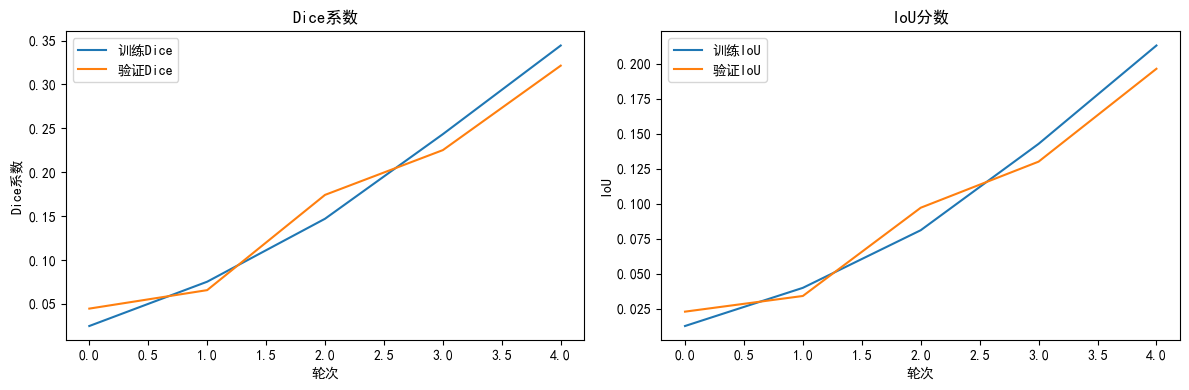

In [13]:
# 改进的模型2 - 自定义指标

def dice_coef_torch(y_true, y_pred, smooth=1):
    """用于分割的Dice系数指标"""
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def iou_coef_torch(y_true, y_pred, smooth=1):
    """交并比(IoU)分割指标"""
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    union = torch.sum(y_true_f) + torch.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# 构建U-Net模型（可选指定输入形状）
model2 = UNet(in_channels=1, out_channels=1).to(device)

# 使用自定义指标编译模型
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
criterion2 = nn.BCELoss()

# 显示模型架构摘要
print(f"模型参数总数: {count_parameters(model2):,}")

# 带自定义指标的训练函数
def train_model_with_metrics(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    history = {
        'train_loss': [], 'train_acc': [], 'train_dice': [], 'train_iou': [],
        'val_loss': [], 'val_acc': [], 'val_dice': [], 'val_iou': []
    }
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_dice = 0.0
        train_iou = 0.0
        
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # 计算指标
            pred_masks = (outputs > 0.5).float()
            acc = (pred_masks == masks).float().mean()
            dice = dice_coef_torch(masks, outputs)
            iou = iou_coef_torch(masks, outputs)
            
            train_acc += acc.item()
            train_dice += dice.item()
            train_iou += iou.item()
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_dice = 0.0
        val_iou = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                
                pred_masks = (outputs > 0.5).float()
                acc = (pred_masks == masks).float().mean()
                dice = dice_coef_torch(masks, outputs)
                iou = iou_coef_torch(masks, outputs)
                
                val_acc += acc.item()
                val_dice += dice.item()
                val_iou += iou.item()
        
        # 计算平均值
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        
        # 保存历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        
        print(f'轮次 {epoch+1}/{num_epochs}: '
              f'训练损失: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}, '
              f'验证损失: {val_loss:.4f}, 验证Dice: {val_dice:.4f}, 验证IoU: {val_iou:.4f}')
    
    return history

# 训练模型
history2 = train_model_with_metrics(model2, train_loader, val_loader, criterion2, optimizer2, num_epochs=5)

# 绘制Dice系数和IoU图
plt.figure(figsize=(12,4))

# Dice系数图
plt.subplot(1,2,1)
plt.plot(history2['train_dice'], label='训练Dice')
plt.plot(history2['val_dice'], label='验证Dice')
plt.xlabel('轮次')
plt.ylabel('Dice系数')
plt.legend()
plt.title('Dice系数')

# IoU图
plt.subplot(1,2,2)
plt.plot(history2['train_iou'], label='训练IoU')
plt.plot(history2['val_iou'], label='验证IoU')
plt.xlabel('轮次')
plt.ylabel('IoU')
plt.legend()
plt.title('IoU分数')

plt.tight_layout()
plt.show()

Part 8 续 - 测试结果可视化

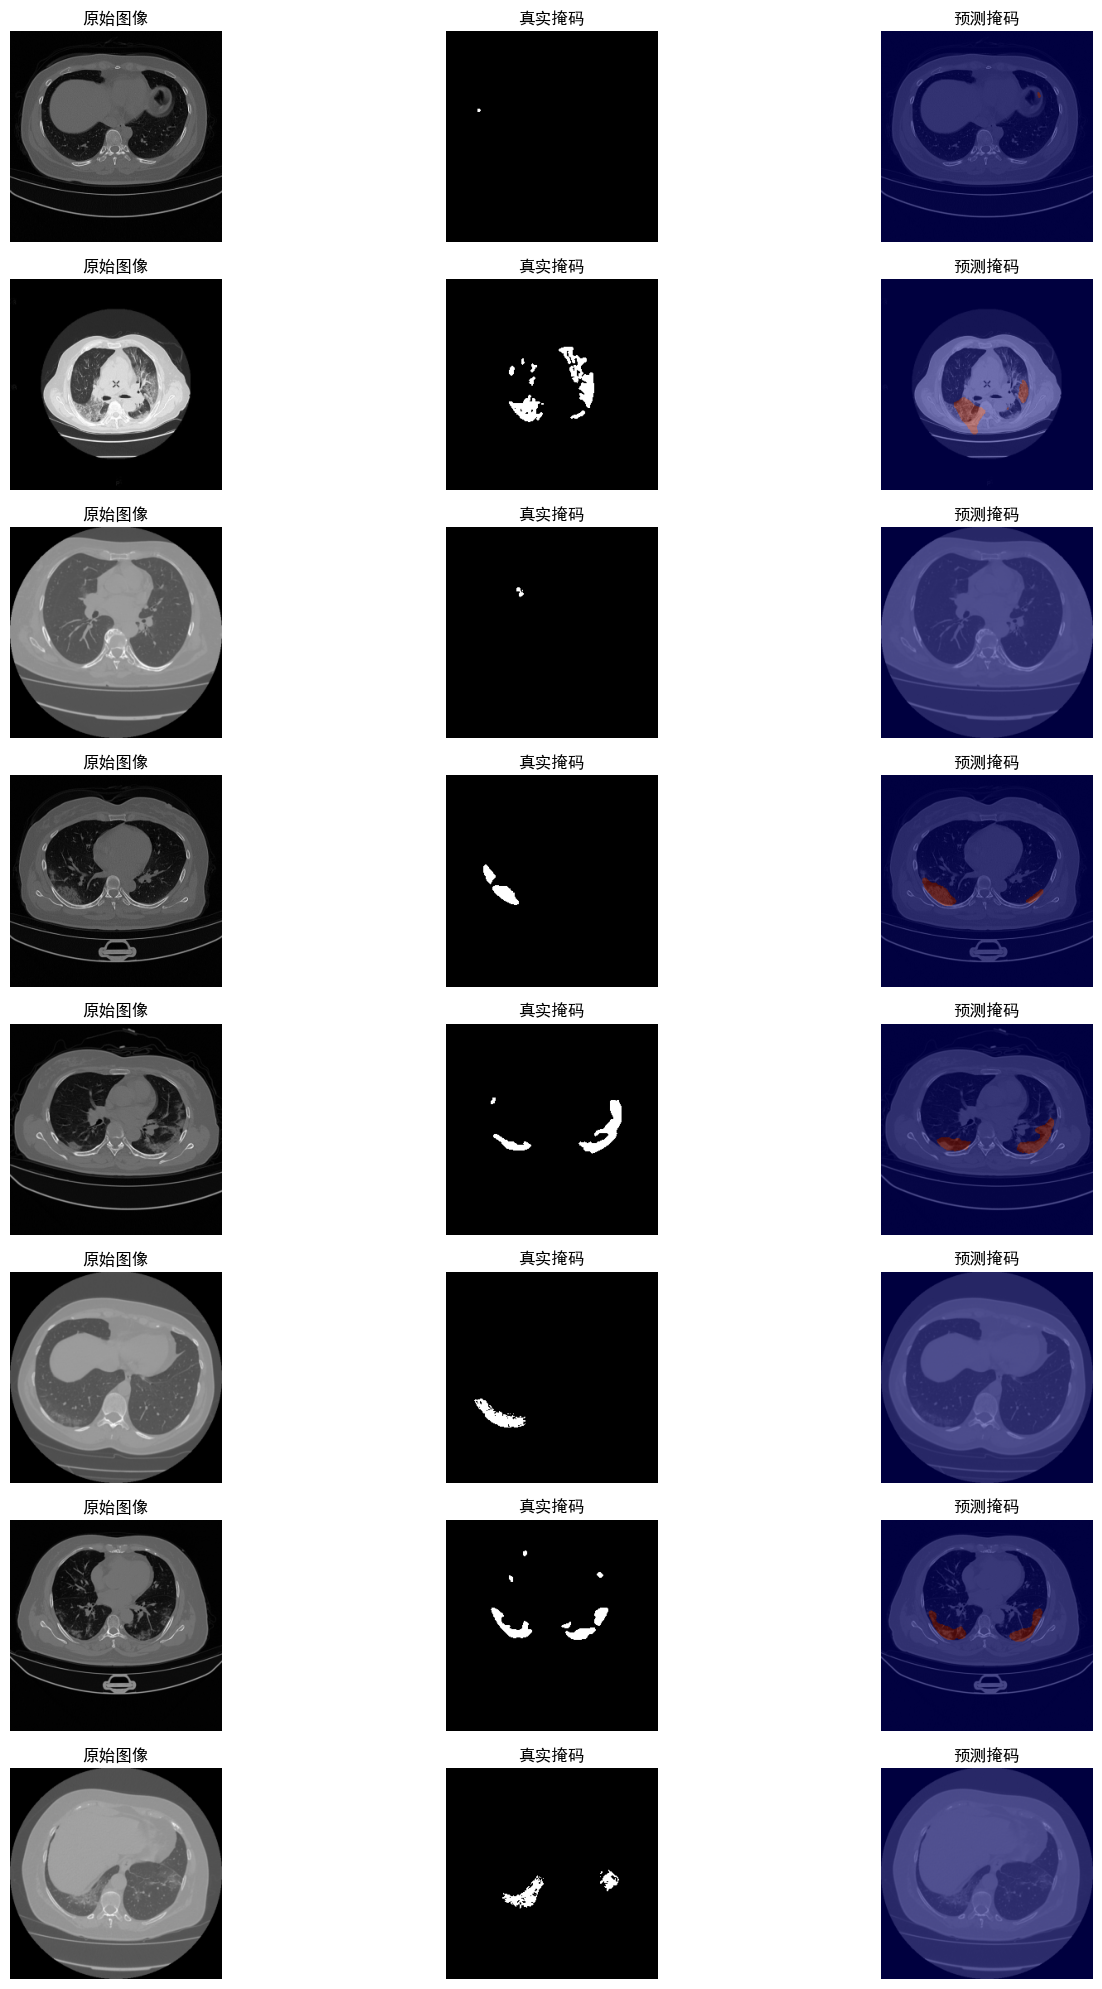

In [14]:
# 获取测试批次（图像和真实掩码）
model2.eval()
with torch.no_grad():
    for imgs, masks_true in test_loader:
        imgs, masks_true = imgs.to(device), masks_true.to(device)
        masks_pred = model2(imgs)
        break

# 转换为CPU用于可视化
imgs_cpu = imgs.cpu()
masks_true_cpu = masks_true.cpu()
masks_pred_cpu = masks_pred.cpu()

n_examples = 8  # 要显示的示例数量（根据需要更改）
plt.figure(figsize=(15, 2.5 * n_examples))  # 高度与示例数量成正比

for i in range(min(n_examples, imgs.shape[0])):
    # 原始图像
    plt.subplot(n_examples, 3, i*3 + 1)
    plt.imshow(imgs_cpu[i][0], cmap='gray')
    plt.title("原始图像")
    plt.axis('off')
    
    # 真实掩码
    plt.subplot(n_examples, 3, i*3 + 2)
    plt.imshow(masks_true_cpu[i][0], cmap='gray')
    plt.title("真实掩码")
    plt.axis('off')
    
    # 预测掩码（叠加在图像上）
    plt.subplot(n_examples, 3, i*3 + 3)
    plt.imshow(imgs_cpu[i][0], cmap='gray')
    plt.imshow((masks_pred_cpu[i][0] > 0.5), cmap='jet', alpha=0.5)
    plt.title("预测掩码")
    plt.axis('off')

plt.tight_layout()
plt.show()

Part 9 - Dice系数和IoU指标说明（图像预测U-Net）

In [15]:
# Dice系数和交并比(IoU)指标说明

"""
Dice系数和交并比(IoU)指标说明

Dice系数和交并比(IoU)是两个广泛用于评估图像分割模型性能的指标，特别是在医学成像中。

Dice系数
Dice系数（也称为Sørensen-Dice指数）测量预测分割掩码和真实掩码之间的重叠。

它的范围从0（无重叠）到1（完全重叠）。

公式：
Dice = 2 * |预测 ∩ 真实| / (|预测| + |真实|)

简单来说，Dice计算两个样本之间的相似性，特别适用于评估类别不平衡的任务，
如病灶或器官分割。

交并比(IoU)
IoU，也称为Jaccard指数，测量预测掩码和真实掩码的交集与并集的比值。

它的范围也是从0（无重叠）到1（完全重叠）。

公式：
IoU = |预测 ∩ 真实| / |预测 ∪ 真实|

IoU是比Dice更严格的指标，对假阳性和假阴性的惩罚更重。

解释
更高的值（接近1）表示更好的分割性能。
与简单的像素准确率相比，Dice和IoU更适合，特别是当感兴趣的区域（如病灶）
只占图像的一小部分时。
在实践中，Dice值高于0.8和IoU值高于0.7被认为在医学分割任务中表现强劲。

总结：
两个指标都量化了预测和真实分割掩码之间的重叠，但Dice更宽容，
而IoU更严格。报告这两个指标可以更全面地评估模型的分割质量。
"""

# 计算Dice系数的函数（测量预测和真实值之间的重叠）
def dice_coef_np(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# 计算交并比(IoU)指标的函数（更严格的重叠测量）
def iou_coef_np(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# 循环测试示例，计算并打印每个图像的Dice和IoU
for i in range(min(n_examples, imgs.shape[0])):
    # 计算当前示例的Dice和IoU
    dice = dice_coef_np(masks_true_cpu[i][0].numpy(), (masks_pred_cpu[i][0] > 0.5).numpy())
    iou = iou_coef_np(masks_true_cpu[i][0].numpy(), (masks_pred_cpu[i][0] > 0.5).numpy())
    print(f"示例 {i+1} | Dice: {dice:.3f} | IoU: {iou:.3f}")

示例 1 | Dice: 0.028 | IoU: 0.028
示例 2 | Dice: 0.451 | IoU: 0.292
示例 3 | Dice: 0.018 | IoU: 0.018
示例 4 | Dice: 0.642 | IoU: 0.474
示例 5 | Dice: 0.688 | IoU: 0.524
示例 6 | Dice: 0.001 | IoU: 0.001
示例 7 | Dice: 0.694 | IoU: 0.532
示例 8 | Dice: 0.001 | IoU: 0.001


Part 9 续 - 混淆矩阵和分类报告

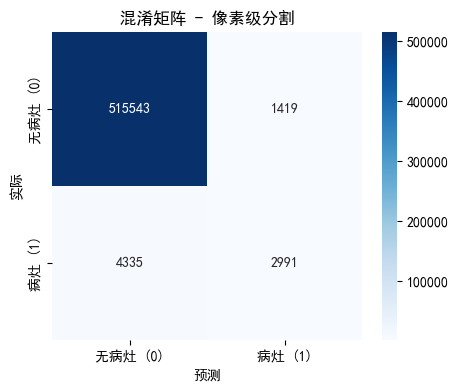

              precision    recall  f1-score   support

     无病灶 (0)     0.9917    0.9973    0.9945    516962
      病灶 (1)     0.6782    0.4083    0.5097      7326

    accuracy                         0.9890    524288
   macro avg     0.8349    0.7028    0.7521    524288
weighted avg     0.9873    0.9890    0.9877    524288



In [16]:
# 收集所有真实和预测像素
all_true = []
all_pred = []

n_examples = masks_true.shape[0]  # 现在没有IndexError；获取批次中的示例数量

# 循环所有示例以展平掩码并收集预测和真实像素
for i in range(n_examples):
    true_mask = masks_true_cpu[i][0].numpy().astype(np.uint8).flatten()  # 展平真实掩码
    pred_mask = (masks_pred_cpu[i][0] > 0.5).numpy().astype(np.uint8).flatten()  # 展平预测掩码（阈值0.5）
    all_true.extend(true_mask)  # 将真实像素添加到列表
    all_pred.extend(pred_mask)  # 将预测像素添加到列表

# 计算像素级分割的混淆矩阵
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['无病灶 (0)', '病灶 (1)'],
            yticklabels=['无病灶 (0)', '病灶 (1)'])
plt.xlabel("预测")
plt.ylabel("实际")
plt.title("混淆矩阵 - 像素级分割")
plt.show()

# 分类报告
target_names = ['无病灶 (0)', '病灶 (1)']
print(classification_report(all_true, all_pred, target_names=target_names, digits=4))

Part 10 - 使用U-Net模型2进行图像预测

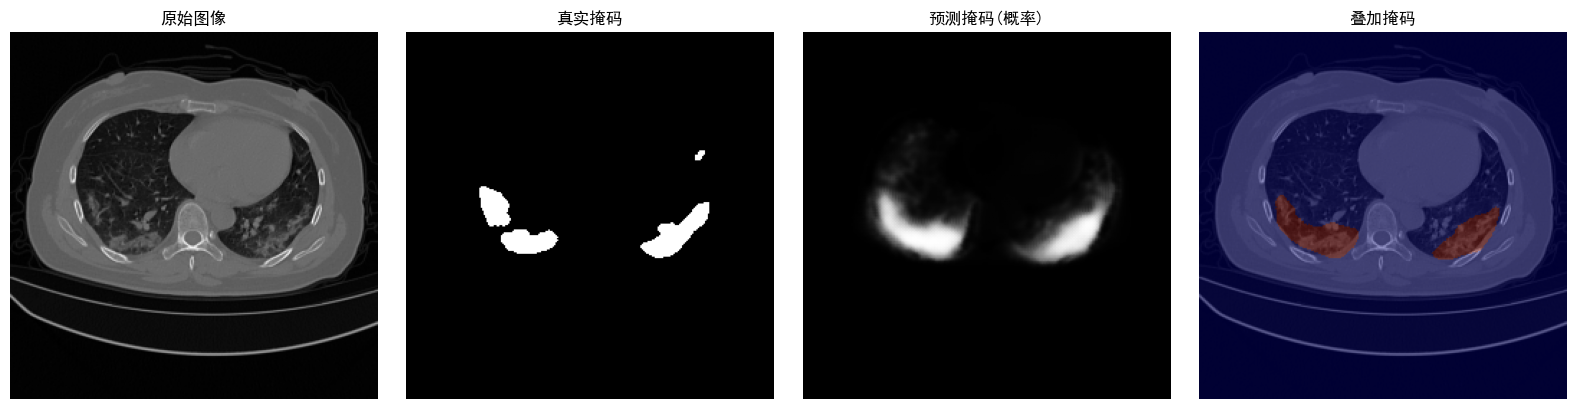

像素级准确率(图像): 0.9855
['Jun_coronacases_case10_100.png', 'Jun_coronacases_case10_101.png', 'Jun_coronacases_case10_102.png', 'Jun_coronacases_case10_103.png', 'Jun_coronacases_case10_104.png']
Dice: 0.7460656174979995
IoU : 0.5950659293917482


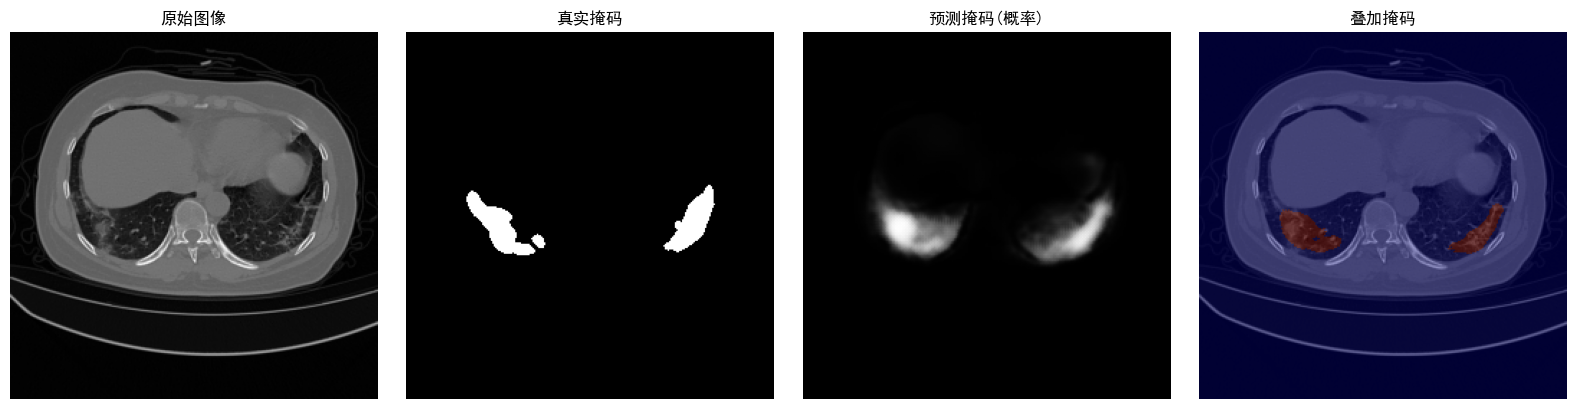

[Jun_coronacases_case10_100.png] 准确率: 0.9855 | Dice: 0.6658 | IoU: 0.4992


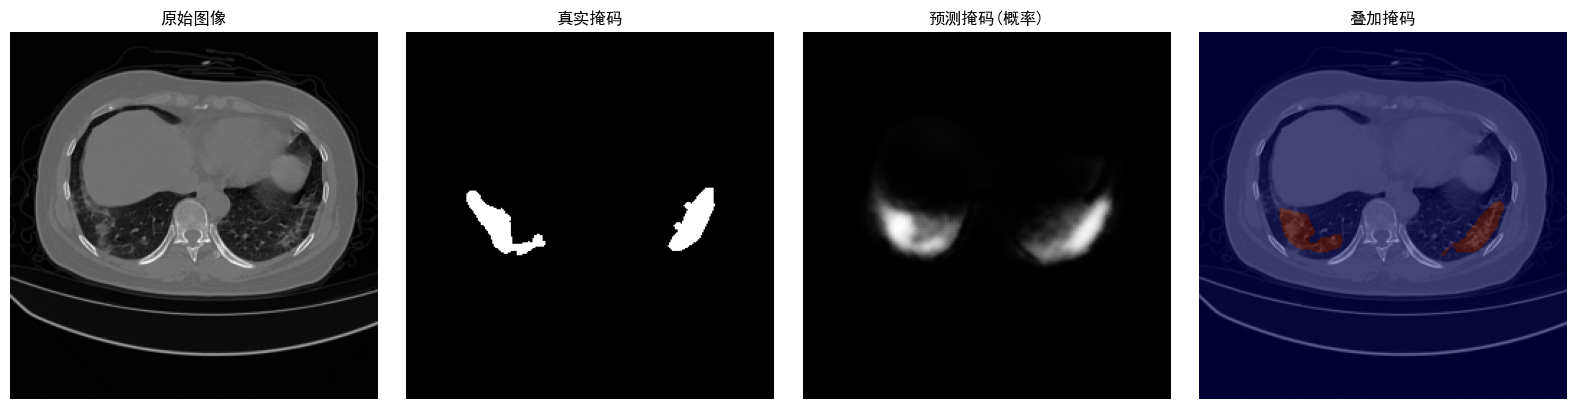

[Jun_coronacases_case10_101.png] 准确率: 0.9874 | Dice: 0.7047 | IoU: 0.5442


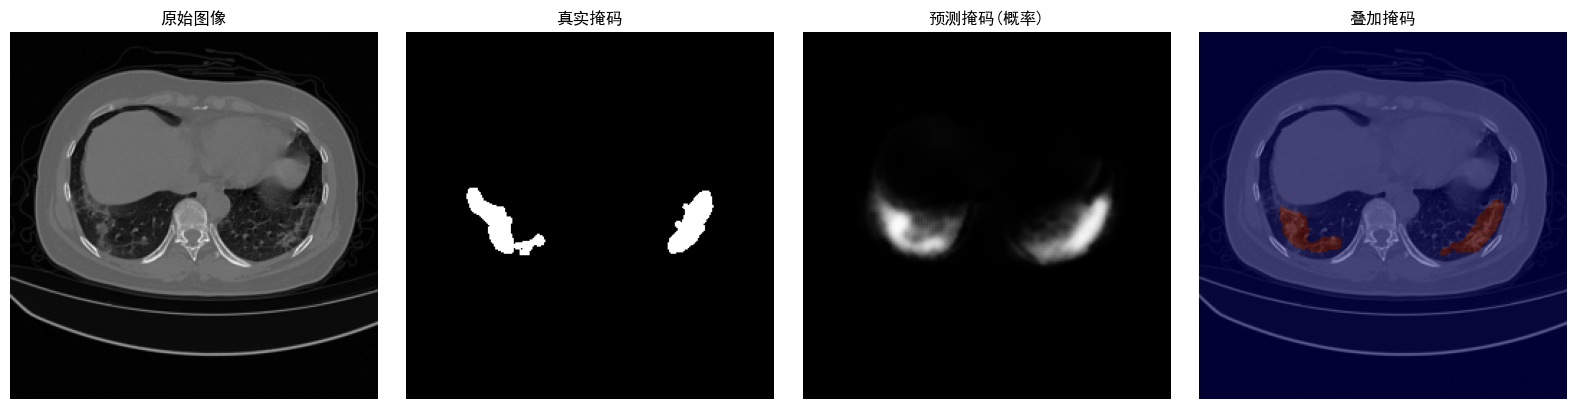

[Jun_coronacases_case10_102.png] 准确率: 0.9890 | Dice: 0.7461 | IoU: 0.5951


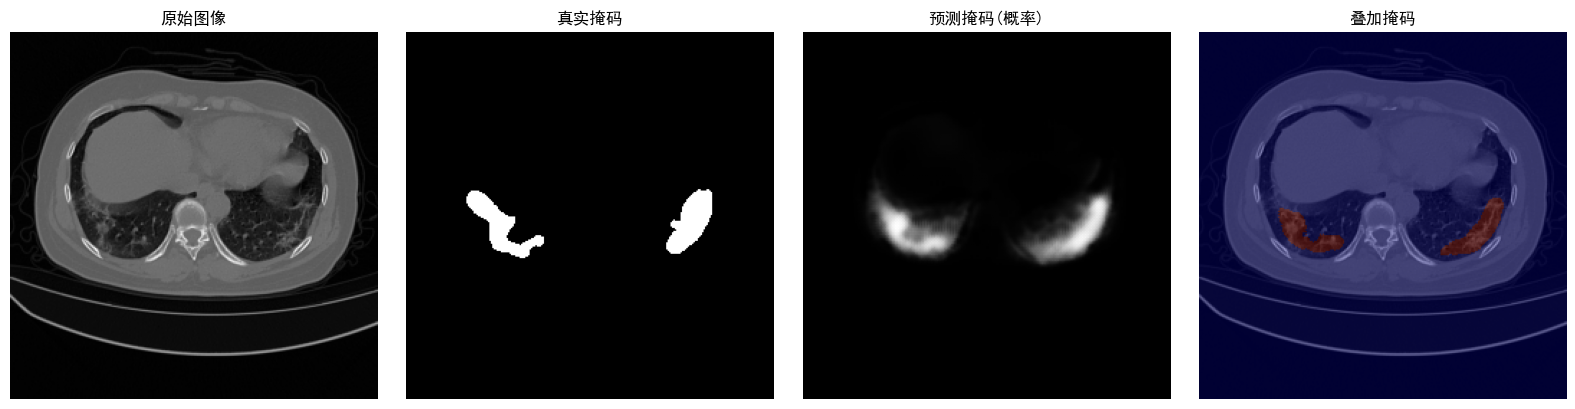

[Jun_coronacases_case10_103.png] 准确率: 0.9861 | Dice: 0.6971 | IoU: 0.5352


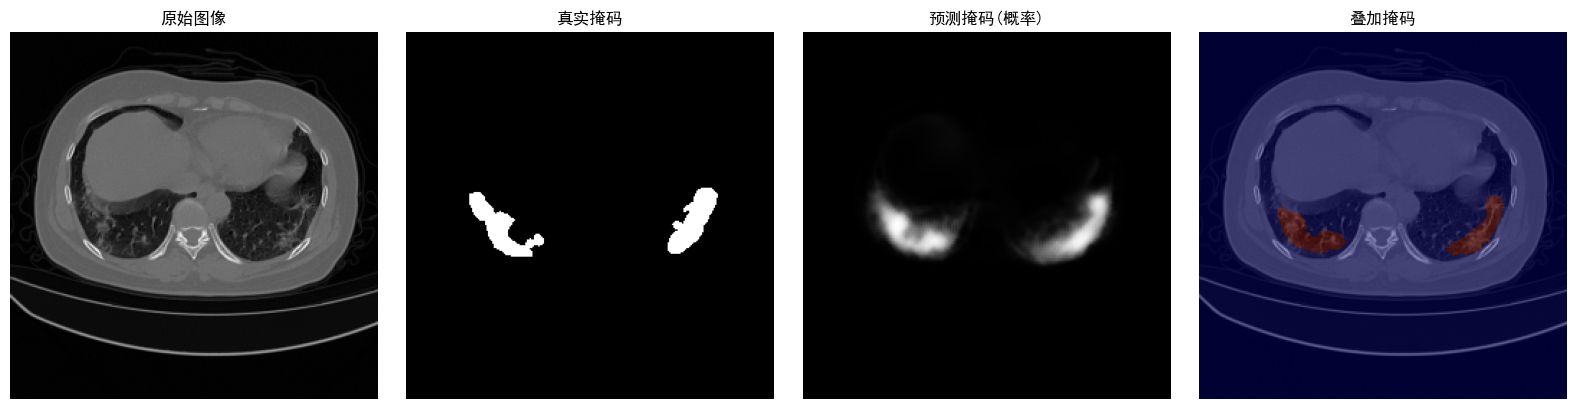

[Jun_coronacases_case10_104.png] 准确率: 0.9861 | Dice: 0.6924 | IoU: 0.5296


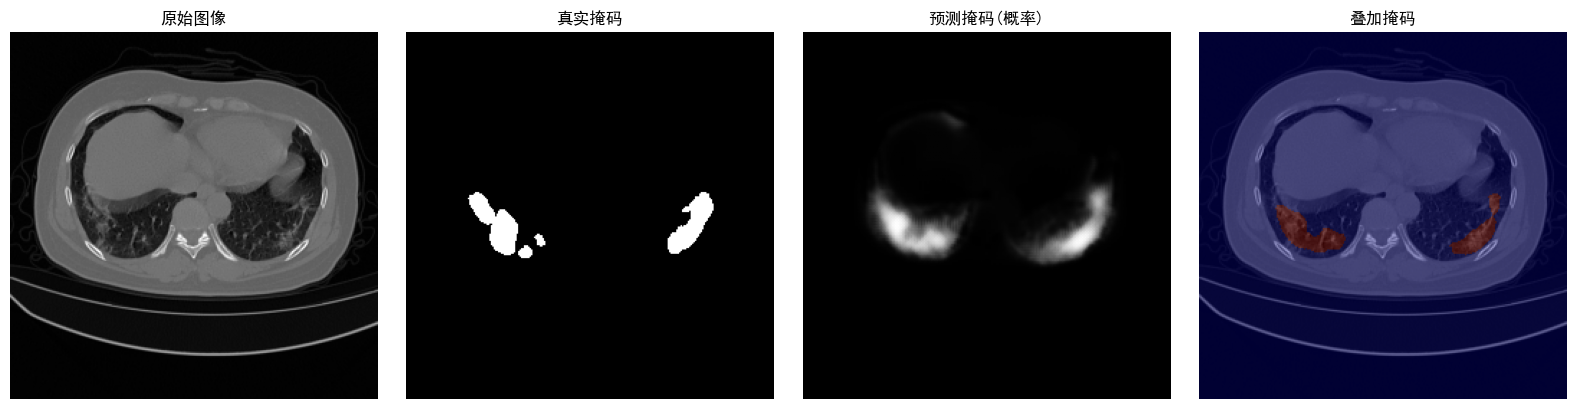

[Jun_coronacases_case10_105.png] 准确率: 0.9864 | Dice: 0.6751 | IoU: 0.5097


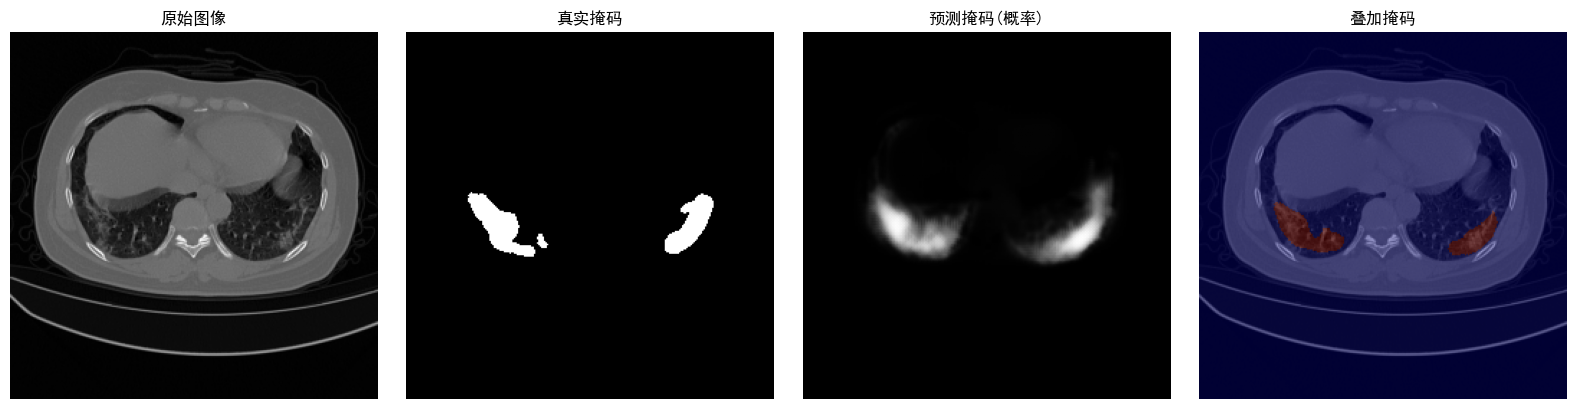

[Jun_coronacases_case10_106.png] 准确率: 0.9861 | Dice: 0.6848 | IoU: 0.5208


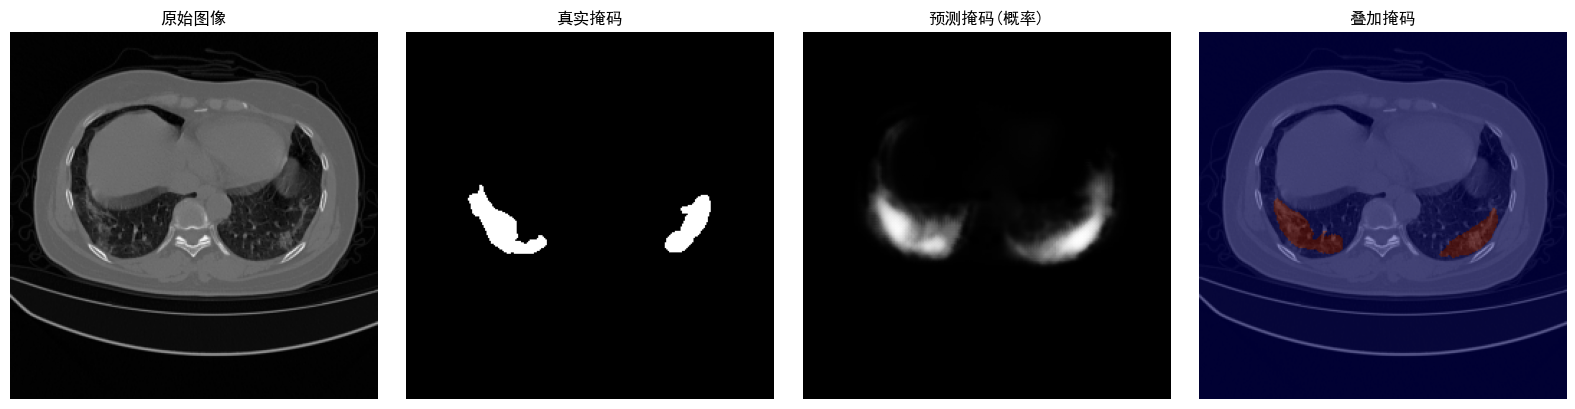

[Jun_coronacases_case10_107.png] 准确率: 0.9879 | Dice: 0.7311 | IoU: 0.5762


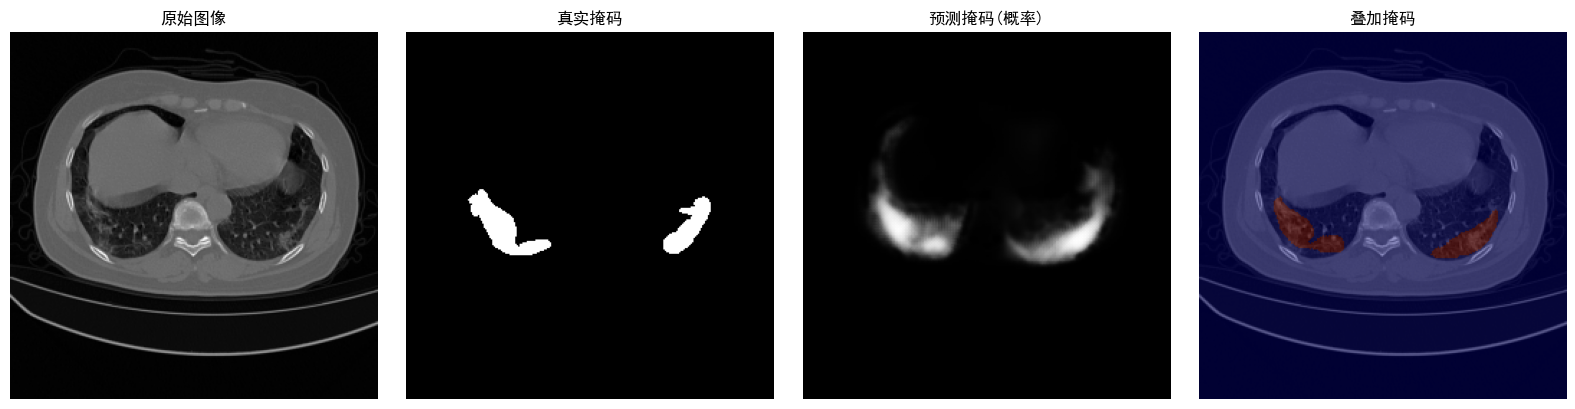

[Jun_coronacases_case10_108.png] 准确率: 0.9872 | Dice: 0.7204 | IoU: 0.5632


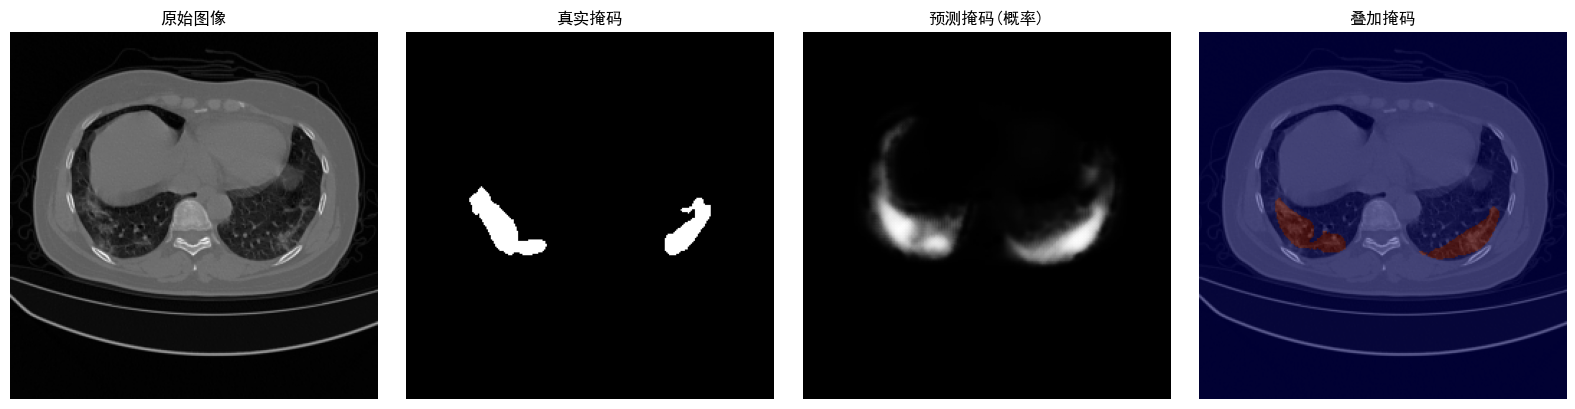

[Jun_coronacases_case10_109.png] 准确率: 0.9875 | Dice: 0.7273 | IoU: 0.5716

平均准确率(10张图像): 0.9869
平均Dice(10张图像): 0.7045
平均IoU(10张图像): 0.5445


In [20]:
# 保存神经网络模型 - U-Net 2
torch.save(model2.state_dict(), 'unet_2_segmentacao.pth')
torch.save(model2, 'unet_2_segmentacao_complete.pth')

# 1. 新保存模型的路径
model_path2 = 'unet_2_segmentacao.pth'

# 2. 加载保存的模型
model2_loaded = UNet(in_channels=1, out_channels=1).to(device)
model2_loaded.load_state_dict(torch.load(model_path2))
model2_loaded.eval()

# 3. 从数据集中选择一个图像
img_filename = 'Jun_coronacases_case10_141.png'  # 列表中的任何文件名！
img_path = os.path.join(frames_dir, img_filename)
mask_path = os.path.join('./archive/masks', img_filename)

# 4. 加载和预处理图像（256x256，1通道）
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
img = img / 255.0
img_input = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0).to(device)  # 形状(1, 1, 256, 256)

# 5. 进行预测
with torch.no_grad():
    mask_pred = model2_loaded(img_input)[0, 0].cpu().numpy()
mask_pred_bin = (mask_pred > 0.5).astype(np.uint8)

# 6. （可选）加载真实掩码
mask_true = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_true = cv2.resize(mask_true, (256, 256))
mask_true_bin = (mask_true > 127).astype(np.uint8)

# 7. 可视化一切
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('原始图像')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(mask_true_bin, cmap='gray')
plt.title('真实掩码')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(mask_pred, cmap='gray')
plt.title('预测掩码(概率)')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(img, cmap='gray')
plt.imshow(mask_pred_bin, cmap='jet', alpha=0.4)
plt.title('叠加掩码')
plt.axis('off')
plt.tight_layout()
plt.show()

# 8. 计算该图像的像素级准确率：
accuracy_pixel = np.mean(mask_true_bin == mask_pred_bin)
print(f"像素级准确率(图像): {accuracy_pixel:.4f}")

# 路径配置
img_dir = './archive/frames'
mask_dir = './archive/masks'

# 列出目录中前5个图像文件名
img_filenames = sorted(os.listdir(img_dir))
print(img_filenames[:5])

# 为单个掩码计算Dice和IoU
print('Dice:', dice_coef_np(mask_true_bin, mask_pred_bin))
print('IoU :', iou_coef_np(mask_true_bin, mask_pred_bin))

# 批量评估多个图像
acuracias = []
dices = []
ious = []

# 循环前10个图像（或任何所需范围）
for img_filename in img_filenames[:10]:
    img_path = os.path.join(img_dir, img_filename)
    mask_path = os.path.join(mask_dir, img_filename)
    
    # 加载图像（灰度，调整大小到256x256，归一化）
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img_input = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0).to(device)

    # 加载真实掩码
    mask_true = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_true = cv2.resize(mask_true, (256, 256))
    mask_true_bin = (mask_true > 127).astype(np.uint8)
    
    # 预测
    with torch.no_grad():
        mask_pred = model2_loaded(img_input)[0, 0].cpu().numpy()
    mask_pred_bin = (mask_pred > 0.5).astype(np.uint8)
    
    # 指标
    accuracy_pixel = np.mean(mask_true_bin == mask_pred_bin)
    acuracias.append(accuracy_pixel)
    
    dice = dice_coef_np(mask_true_bin, mask_pred_bin)
    iou = iou_coef_np(mask_true_bin, mask_pred_bin)
    dices.append(dice)
    ious.append(iou)
    
    # 可视化（可选）
    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    plt.imshow(img, cmap='gray')
    plt.title('原始图像')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(mask_true_bin, cmap='gray')
    plt.title('真实掩码')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(mask_pred, cmap='gray')
    plt.title('预测掩码(概率)')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask_pred_bin, cmap='jet', alpha=0.4)
    plt.title('叠加掩码')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"[{img_filename}] 准确率: {accuracy_pixel:.4f} | Dice: {dice:.4f} | IoU: {iou:.4f}")

print(f"\n平均准确率(10张图像): {np.mean(acuracias):.4f}")
print(f"平均Dice(10张图像): {np.mean(dices):.4f}")
print(f"平均IoU(10张图像): {np.mean(ious):.4f}")